# Weather file - visualization
- Main task: visualizing weather station locations, yield, & climatology of sites
- Main input:
    - weather station list & detail
    - USDA NASS maize yield data
    - compiled weater data (temp, rh, precip, solrad)
- Main output: 
    - weather stations map
    - yield map & station locations
    - climatology: temp & precip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

from scipy.stats.stats import pearsonr
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5
from palettable.colorbrewer.sequential import Purples_9

# my own functions
from funcs import CC_VPD

In [2]:
def CC_VPD(temp, rh):
    """
    function that calculates VPD with temperature and RH
    RH values range between 0 & 1 (fraction, not %)
    """
    # constant parameters
    Tref = 273.15  # reference temperature
#    Es_Tref = 6.11 # saturation vapor pressure at reference temperature (mb)
    Es_Tref = 0.611 # saturation vapor pressure at reference temperature (kPa)
    Lv = 2.5e+06   # latent heat of vaporation (J/kg)
    Rv = 461       # gas constant for moist air (J/kg)
    
    # transformed temperature inputs
    Tair = temp + Tref
    
    # Clausius-Clapeyron relation
    es = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tair))
    e = es*rh
    vpd = es-e
    
    return(vpd)

### 1. Overall site-year coverage

Text(0.5, 0, 'stations')

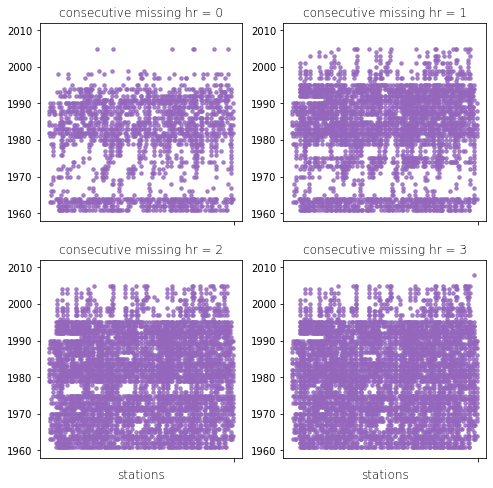

In [7]:
siteyear_ctr0 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr0.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr1 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv',
                           dtype={'site': object}, usecols=[1,2]) 
siteyear_ctr3 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr3.csv',
                           dtype={'site': object}, usecols=[1,2]) 

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(siteyear_ctr0.site, siteyear_ctr0.year, alpha=0.8, color='tab:purple', s=12)
ax1.set_ylim(1958, 2012)
ax1.set_xticks('')
ax1.set_title('consecutive missing hr = 0', fontweight='light')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(siteyear_ctr1.site, siteyear_ctr1.year, alpha=0.8, color='tab:purple', s=12)
ax2.set_ylim(1958, 2012)
ax2.set_xticks('')
ax2.set_title('consecutive missing hr = 1', fontweight='light')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(siteyear_ctr2.site, siteyear_ctr2.year, alpha=0.8, color='tab:purple', s=12)
ax3.set_ylim(1958, 2012)
ax3.set_xticks('')
ax3.set_title('consecutive missing hr = 2', fontweight='light')
ax3.set_xlabel('stations', fontsize=12, fontweight='light')

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(siteyear_ctr3.site, siteyear_ctr3.year, alpha=0.8, color='tab:purple', s=12)
ax4.set_ylim(1958, 2012)
ax4.set_xticks('')
ax4.set_title('consecutive missing hr = 3', fontweight='light')
ax4.set_xlabel('stations', fontsize=12, fontweight='light')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/siteyears.png', format='png', dpi=800)

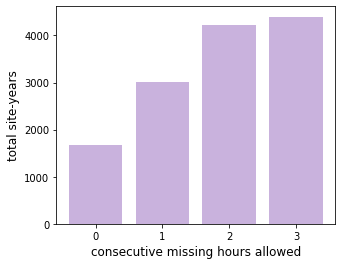

In [8]:
siteyears_ctr0 = siteyear_ctr0.shape[0]
siteyears_ctr1 = siteyear_ctr1.shape[0]
siteyears_ctr2 = siteyear_ctr2.shape[0]
siteyears_ctr3 = siteyear_ctr3.shape[0]

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ctrhr = [0,1,2,3]
siteyears = [siteyears_ctr0, siteyears_ctr1, siteyears_ctr2, siteyears_ctr3]
ax.bar(ctrhr, siteyears, alpha=0.5, color='tab:purple')
ax.set_xlabel('consecutive missing hours allowed', fontsize=12)
ax.set_ylabel('total site-years', fontsize=12)
ax.set_xticks([0,1,2,3])

### 2. Stations map - critical hour: 2
- Main input: reading in **wea_summary.csv**
- Main output: **df_summary**

In [2]:
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', index_col=0)
df_summary.head()

site  class                    station state  tzone     lat     lon  \
0  722010      1         KEY WEST INTL ARPT    FL     -5  24.550 -81.750   
1  722020      1              MIAMI INTL AP    FL     -5  25.817 -80.300   
2  722030      1  WEST PALM BEACH INTL ARPT    FL     -5  26.683 -80.100   
3  722050      1          ORLANDO INTL ARPT    FL     -5  28.433 -81.333   
4  722056      1      DAYTONA BEACH INTL AP    FL     -5  29.183 -81.067   

   years       area  perct_irri  
0     25   84670.90   60.802507  
1     29  160227.65   62.002065  
2     19  145225.95   78.435473  
3     19   59312.40   55.098924  
4     19   23625.30   50.088347

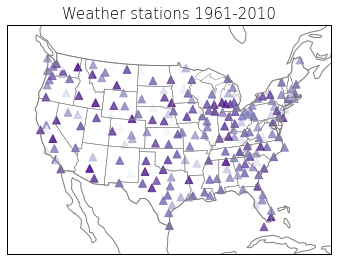

In [3]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

# sites not filtered
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_summary.lon, df_summary.lat, transform=ccrs.PlateCarree(), s=60, marker='^',
            c=df_summary.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Weather stations 1961-2010', fontweight='light', fontsize=15)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation.png', format='png', dpi=800)

### 3. Filtering based on irrigation & planting area
- Irrigation & planting area information from 4 census data of 1997, 2002, 2007, & 2012
- Assigning irrigation & planting area info to valid site-years
- Main output: **df_summary**

In [4]:
df_obs = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/obs_areairri.csv')

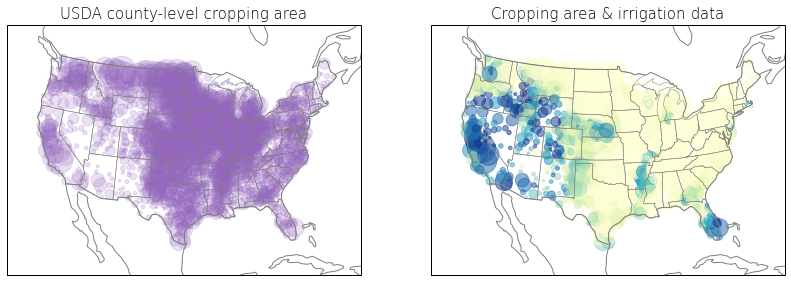

In [5]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_obs.lon.astype(float), df_obs.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=df_obs.crop_area/1500, c='tab:purple', alpha=0.2)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('USDA county-level cropping area', fontweight='light', fontsize=15)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                        central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
ax2.scatter(df_obs.lon, df_obs.lat, transform=ccrs.PlateCarree(), 
           c=df_obs.perct_irri*0.1, vmin=0, vmax=10, s=df_obs.crop_area/1500,
           cmap=YlGnBu_8.mpl_colormap, alpha=0.5)

ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Cropping area & irrigation data', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/area_irri.png', format='png', dpi=800)

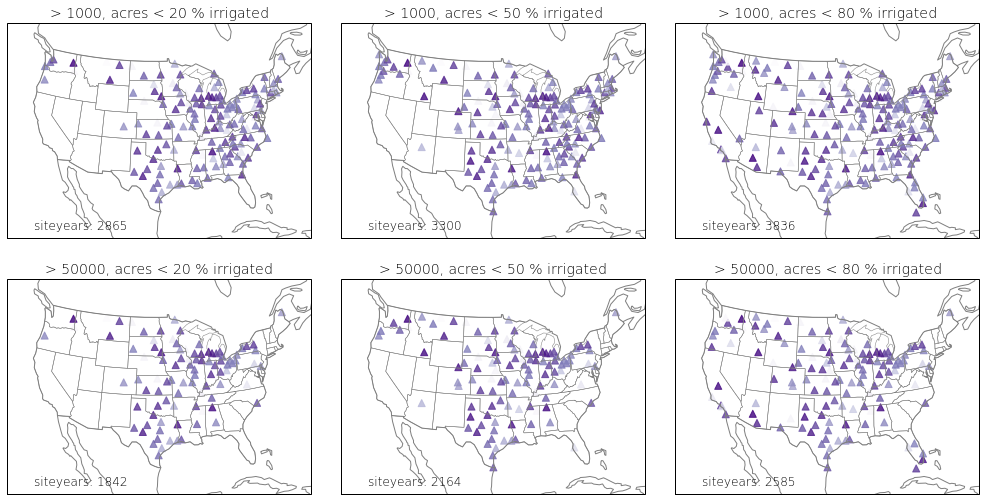

In [6]:
area = [1000, 1000, 1000, 50000, 50000, 50000]
irri = [20, 50, 80, 20, 50, 80]

# sites not filtered
fig = plt.figure(figsize=(15,8))

for i in np.arange(1,7):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    df_filtered = df_summary[(df_summary.area > area[i-1]) & (df_summary.perct_irri < irri[i-1])]     
    ax.scatter(df_filtered.lon, df_filtered.lat, 
               transform=ccrs.PlateCarree(), s=50, marker='^', 
               c=df_filtered.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('> {}, acres < {} % irrigated'.format(area[i-1], irri[i-1]),
                 fontweight='light', fontsize=14)
    ax.text(-103, 23, 'siteyears: {}'.format(df_filtered.years.sum()),
            horizontalalignment='right', transform=ccrs.PlateCarree(),
            fontweight='light', fontsize=12)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/stations_filters.png', format='png', dpi=800)

### 4. Climate Space & Climatology
- Main outputs:
    - df_siteyears_weamean

In [3]:
# reading in weather data
#df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
#df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
#df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
#df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv', index_col= 0)

# interpolating weather data 
#df_temp = df_temp.interpolate()
#df_rh = df_rh.interpolate()
#df_precip = df_precip.interpolate()
#df_solrad = df_solrad.interpolate()

In [5]:
# filtering sites based on planting area & irrigation
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', 
                            usecols=[1,2], dtype='str') 
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', 
                         index_col=0, dtype={'site': str})
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]
siteyears = siteyear_ctr2[siteyear_ctr2.site.isin(df_filtered.site)] # df_filtered accounts for irrigation & planting area
                                                                     # and has AK, GU, HI, & PR removed already

In [6]:
# converting the dataframe-style weather data into a single long-form list
# - only selecting weather data for filtered siteyears
# - plotting data for growing season between 4/1 - 10/31
temp_all = [np.nan]*siteyears.shape[0]
rh_all = [np.nan]*siteyears.shape[0]
precip_all = [np.nan]*siteyears.shape[0]
solrad_all = [np.nan]*siteyears.shape[0]

for i in np.arange(siteyears.shape[0]):
    # growing season temp mean for each site-year
    temp = df_temp.loc[siteyears.iloc[i,1] + '-04-01' : 
                       siteyears.iloc[i,1] +'-10-31', 
                       siteyears.iloc[i,0]].mean()
    # growing season RH mean for each site-year
    rh = df_rh.loc[siteyears.iloc[i,1] + '-04-01' : 
                   siteyears.iloc[i,1] +'-10-31', 
                   siteyears.iloc[i,0]].mean()
    # growing season precip sum for each site-year
    precip = df_precip.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].sum()

    # 
    solrad = df_solrad.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].mean()
    
    
    temp_all[i] = temp
    rh_all[i] = rh
    precip_all[i] = precip
    solrad_all[i] = solrad
    
# calculating VPD based on temperature & RH
vpd_all = []
for i in np.arange(len(temp_all)):
    vpd_all.append(CC_VPD(temp_all[i], rh_all[i]/100))
    
# storing output in dataframe
df_siteyears_weamean = siteyears.copy()
df_siteyears_weamean['temp'] = list(temp_all)
df_siteyears_weamean['rh'] = list(rh_all)
df_siteyears_weamean['precip'] = list(precip_all)
df_siteyears_weamean['solrad'] = list(solrad_all)
df_siteyears_weamean['vpd'] = list(vpd_all)
df_siteyears_weamean = pd.merge(df_siteyears_weamean, df_filtered, on='site')

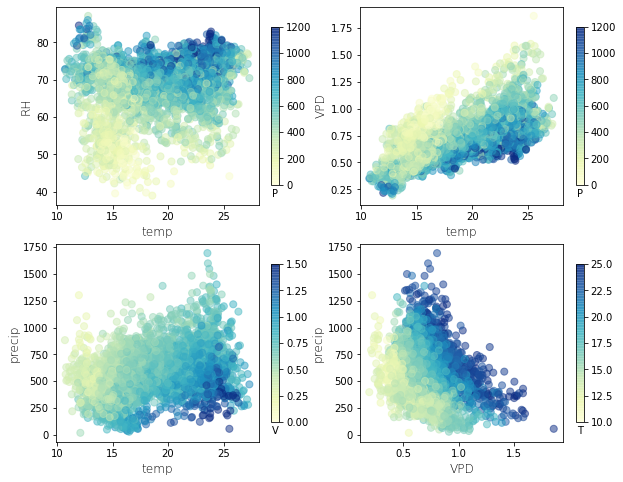

In [7]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(10,8))

#cm = plt.cm.get_cmap('YlGnBu')

weadata = [[temp_all, rh_all, precip_all], [temp_all, vpd_all, precip_all],
           [temp_all, precip_all, vpd_all], [vpd_all, precip_all, temp_all]]

titles = [['temp', 'RH', 'P'], ['temp', 'VPD', 'P'], 
          ['temp', 'precip', 'V'], ['VPD', 'precip', 'T']]

ranges = [[0,1200], [0,1200], [0,1.5], [10,25]]

for i in np.arange(4):
    ax = fig.add_subplot(2,2,i+1)
    sc = ax.scatter(weadata[i][0], weadata[i][1], c=weadata[i][2],
                    alpha=0.5, s=50, vmin=ranges[i][0], vmax=ranges[i][1], cmap=YlGnBu_8.mpl_colormap)
    ax.set_xlabel(titles[i][0], fontsize=12, fontweight='light')
    ax.set_ylabel(titles[i][1], fontsize=12, fontweight='light')
    cbar = fig.colorbar(sc, shrink=0.8)
    cbar.ax.set_xlabel(titles[i][2])

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/climate_space.png', format='png', dpi=800)

### Averaging based on sites

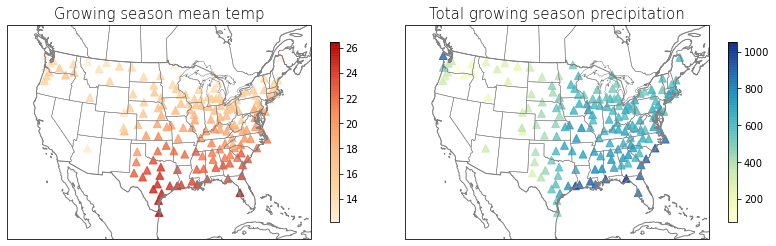

In [8]:
df_sitemeans = df_siteyears_weamean.groupby('site').mean() # site-mean wea data

# setting up figure
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_sitemeans.lon, df_sitemeans.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=df_sitemeans.temp, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_sitemeans.lon, df_sitemeans.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=df_sitemeans.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Total growing season precipitation', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/climate_map.png', format='png', dpi=800)

### Plotting for specific year

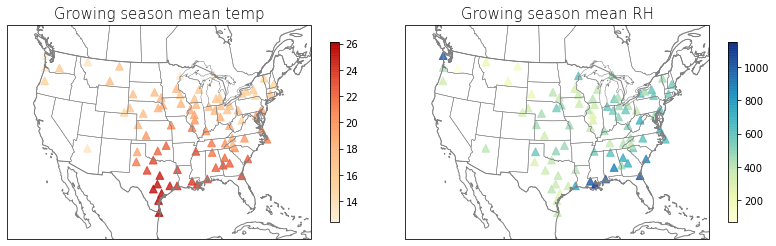

In [11]:
# subset of year
df_year = df_siteyears_weamean[df_siteyears_weamean.year=='1988']

# setting up figure
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=df_year.temp, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=df_year.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Growing season mean RH', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)

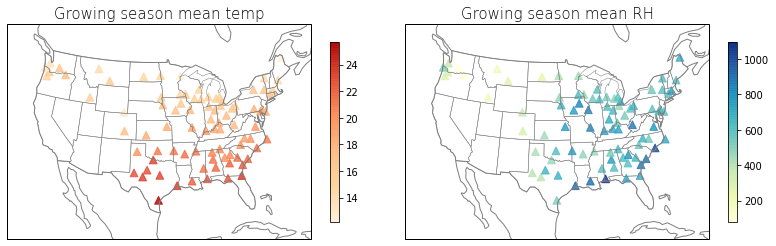

In [113]:
# subset of year
df_year = df_siteyears_weamean[df_siteyears_weamean.year=='1961']

# setting up figure
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=df_year.temp, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=df_year.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Growing season mean RH', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)

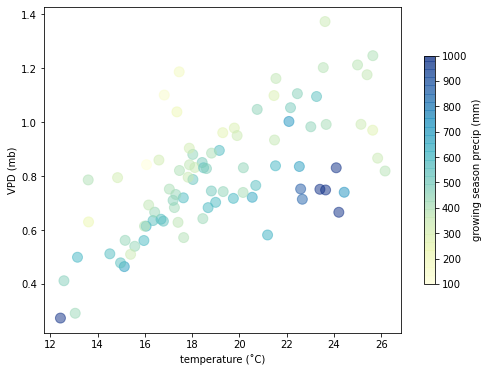

In [12]:
# subset of year
df_year = df_siteyears_weamean[df_siteyears_weamean.year=='1988']

fig = plt.figure(figsize=(8,6))
sc = plt.scatter(df_year.temp, df_year.vpd, c=df_year.precip, cmap=YlGnBu_8.mpl_colormap,
                 alpha=0.5, s=100, vmin=100, vmax=1000)
plt.xlabel('temperature (ËšC)')
plt.ylabel('VPD (mb)')
cbar = fig.colorbar(sc, shrink=0.7)
cbar.set_label('growing season precip (mm)')

### 5.. Overlay site locations with past yield data
- Main input:
    - /data/NASS_cropdata/**stateID.txt**
    - /data/NASS_cropdata/**countyID.txt**
    - /data/NASS_cropdata/**lat_county.txt**
    - /data/NASS_cropdata/**lon_county.txt**
    - /data/NASS_cropdata/**corn_yield.txt**
    - /data/NASS_cropdata/**corn_area.txt**   
- Main output:
    - /figs/**sites_obsyield.png**

#### 5.1 Reading in USDA NASS yield data

In [393]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)
print(df.shape)

(326340, 7)


#### 5.2 Subsetting data for year 1961-2010

In [394]:
df_subset = pd.DataFrame()
years = np.arange(1961,2010)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_subset = pd.concat([df_subset, data])

# calculating mean yield & area planted across 1961-1990
df_sitemean = df_subset.groupby(['state_id', 'county_id']).mean()
df_sitemean = df_sitemean.reset_index()

#### 5.3 Visualization

Text(0, 0.5, 'yield (tons/ha)')

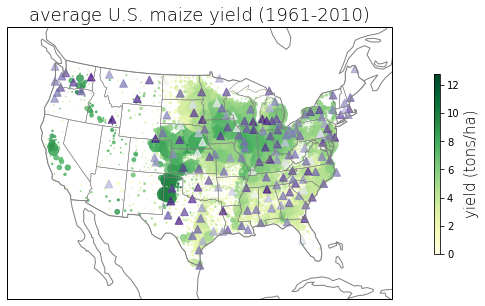

In [408]:
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

# units used to convert maize yield
lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

# filtering sites from df_summary 
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]     

# setting up figure
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sitemean['lon'], df_sitemean['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax.scatter(df_filtered.lon.astype(float), df_filtered.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=60, marker='^',
           c=df_filtered.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)
ax.set_title('Site Locations', fontweight='light', fontsize=18)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('average U.S. maize yield (1961-2010)', 
              fontweight='light', fontsize=18)

yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)', fontweight='light', fontsize=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_obsyield.png', format='png', dpi=800)